# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.feather`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Load time series data

In [2]:
# Read time series data from the binary file that clean_us_data.ipynb produces
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
cases = pd.read_feather(cases_file).set_index("FIPS")
dates = pd.read_feather(dates_file)["date"].to_numpy()
cases.head()

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2


In [3]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

## Aliasing in time series for sparsely-populated counties

Because these time series are integer-valued, there can be problems with aliasing. 
Here are some examples of what aliasing looks like (The `graph_examples()` function is defined in [util.py](./util.py))

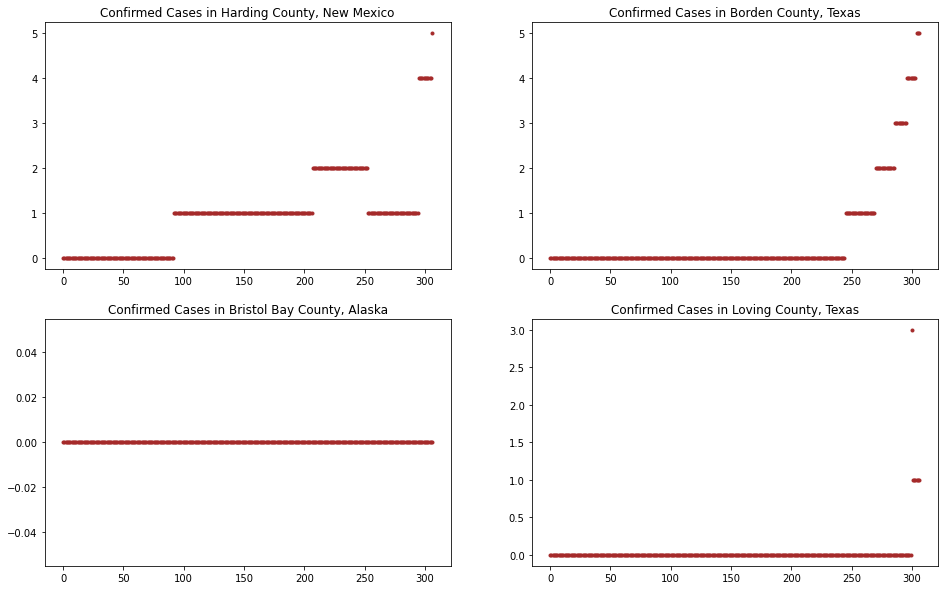

In [4]:
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].array, axis=1) < 10))

## Filter time series that are subject to aliasing

To avoid problems due to aliasing, we will restrict the analysis
in the rest of this notebook to time series whose maximum values
go above a threshold.

In [5]:

alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].array, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].array, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].array[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].array[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorDtype):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,153,3
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,573,0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,31,1
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,149,0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,189,2
...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,438,2
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,241,0
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,190,0


# Warm-up: Fit a straight line

We use sklearn's implementation of [BGFS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) as the optimizer.

In [6]:
# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].array.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,"{'fun': 9322499.465252962, 'jac': [0.0, 25276....",9.696397,-259.000000,[-259. -249.30360297 -239.60720595 -229...,0.947165
1003,Alabama,Baldwin,223234,573,0,"{'fun': 297368098.3800436, 'jac': [0.0, 189912...",26.466218,-259.000000,[-2.59000000e+02 -2.32533782e+02 -2.06067564e+0...,0.845529
1005,Alabama,Barbour,24686,31,1,"{'fun': 900908.6222100473, 'jac': [-0.73341653...",5.198293,-181.131954,[-1.81131954e+02 -1.75933661e+02 -1.70735368e+0...,0.977491
1007,Alabama,Bibb,22394,149,0,"{'fun': 1678644.0997036712, 'jac': [-2.0721927...",4.267864,-189.083401,[-189.08340101 -184.81553712 -180.54767323 -176...,0.940155
1009,Alabama,Blount,57826,189,2,"{'fun': 24206090.70126935, 'jac': [0.0, 39143....",8.939977,-259.000000,[-2.59000000e+02 -2.50060023e+02 -2.41120047e+0...,0.868146
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,"{'fun': 6407832.149453462, 'jac': [-12.1071935...",3.185427,-175.526593,[-1.75526593e+02 -1.72341167e+02 -1.69155740e+0...,0.696292
56039,Wyoming,Teton,23464,241,0,"{'fun': 4570224.95099526, 'jac': [-1.024454838...",3.989011,-174.760061,[-1.74760061e+02 -1.70771050e+02 -1.66782039e+0...,0.834461
56041,Wyoming,Uinta,20226,190,0,"{'fun': 1586175.415384396, 'jac': [-0.09313225...",2.606299,-118.610296,[-118.61029558 -116.00399666 -113.39769773 -110...,0.861116


## Graph: Example linear curves

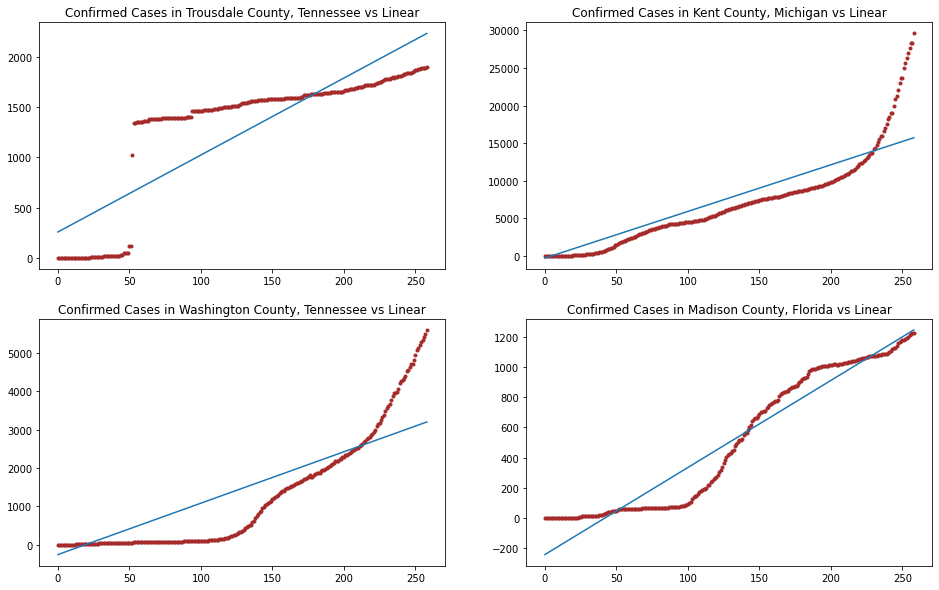

In [7]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

# Define code for fitting any curve

As you can see from the above graphs, straight lines do not explain the data in most of these time series.
Let's fit some more appropriate curves to this data, using the same BGFS optimizer.
First, we'll break out the repetitive parts of the curve-fitting process into a Python function.

In [8]:
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].array.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [9]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate * (X - offset))
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.001, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curves to each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


# Fit exponential curves

In [10]:
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,"{'fun': 127604890.05281116, 'jac': [-269.71101...",0.032159,0.000000,[1.00000000e+00 1.03268179e+00 1.06643168e+00 1...,0.276805
1003,Alabama,Baldwin,223234,573,0,"{'fun': 1380744078.0071058, 'jac': [4061460.49...",0.036710,0.000000,[1.00000000e+00 1.03739188e+00 1.07618191e+00 1...,0.282758
1005,Alabama,Barbour,24686,31,1,"{'fun': 34072989.38536847, 'jac': [18596.64916...",0.029215,0.000000,[1.00000000e+00 1.02964589e+00 1.06017065e+00 1...,0.148686
1007,Alabama,Bibb,22394,149,0,"{'fun': 14204555.459236745, 'jac': [31615.0486...",0.028515,0.000000,[1.00000000e+00 1.02892515e+00 1.05868696e+00 1...,0.493599
1009,Alabama,Blount,57826,189,2,"{'fun': 84834743.66840315, 'jac': [19228.45840...",0.032133,0.000000,[1.00000000e+00 1.03265475e+00 1.06637584e+00 1...,0.537894
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,"{'fun': 2664262.241165242, 'jac': [-0.79162418...",0.027854,0.000000,[1.00000000e+00 1.02824538e+00 1.05728857e+00 1...,0.873723
56039,Wyoming,Teton,23464,241,0,"{'fun': 7159248.972901737, 'jac': [-1762.80736...",0.028685,0.000000,[1.00000000e+00 1.02910053e+00 1.05904789e+00 1...,0.740683
56041,Wyoming,Uinta,20226,190,0,"{'fun': 3661737.5397780323, 'jac': [-92.014670...",0.026761,0.000000,[ 1. 1.02712193 1.05497947 1.083...,0.679381


## Graph: Example exponential curves

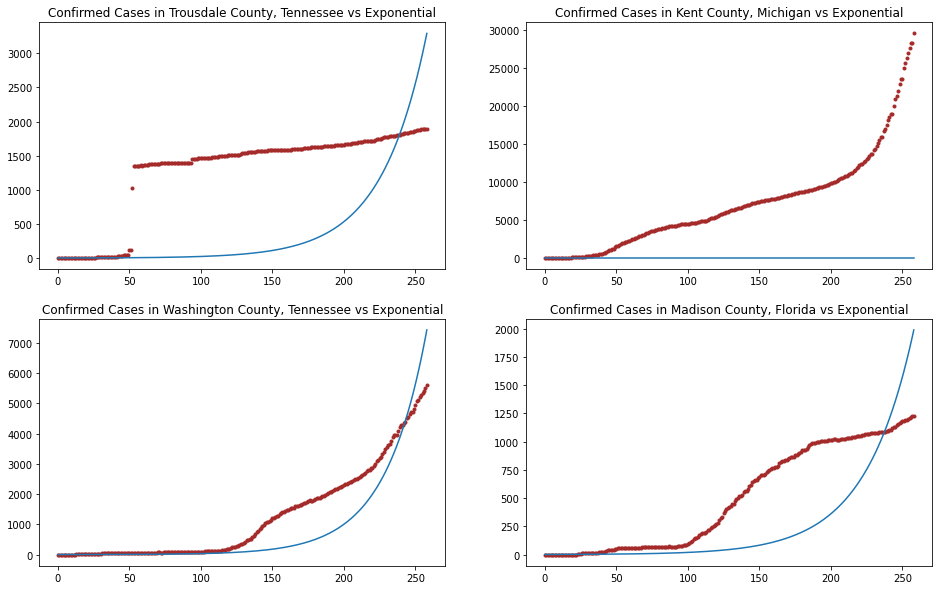

In [11]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

# Fit logistic curves

The [logistic function](https://en.wikipedia.org/wiki/Logistic_function) produces an "S"-shaped curve 
that often closely matches one wave of a disease outbreak.

In [12]:
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,"{'fun': 1704151.9410624641, 'jac': [0.04656662...",2588.942416,0.025243,165.522271,[ 39.07588299 40.05937659 41.06722489 42...,0.990342
1003,Alabama,Baldwin,223234,573,0,"{'fun': 24325329.774342265, 'jac': [-0.3725329...",7693.435432,0.032816,164.591587,[ 34.54996183 35.697209 36.88236758 38...,0.987364
1005,Alabama,Barbour,24686,31,1,"{'fun': 342515.5399019128, 'jac': [-0.00582082...",1136.381406,0.027183,146.296390,[ 20.91097258 21.47629938 22.05660754 22...,0.991442
1007,Alabama,Bibb,22394,149,0,"{'fun': 309851.1191964231, 'jac': [-0.00582082...",1135.701311,0.023653,180.428326,[ 15.69551022 16.06587096 16.44484264 16.832...,0.988954
1009,Alabama,Blount,57826,189,2,"{'fun': 3124283.464231969, 'jac': [-0.09313324...",2726.924145,0.027876,183.046371,[ 16.48050222 16.9434894 17.4193997 17...,0.982982
...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,"{'fun': 2653690.363885422, 'jac': [-0.04656662...",2044.183641,0.024225,259.000000,[ 3.84415638 3.93823724 4.03461606 4...,0.874225
56039,Wyoming,Teton,23464,241,0,"{'fun': 892337.4127723608, 'jac': [-0.03492496...",2319.836531,0.018138,259.000000,[ 20.95561488 21.33565057 21.72251319 22...,0.967678
56041,Wyoming,Uinta,20226,190,0,"{'fun': 1005178.9033202098, 'jac': [0.0, 98.13...",1393.049826,0.016344,259.000000,[ 19.9218464 20.24534842 20.57402494 20.907...,0.911987


## Graph: Example logistic curves

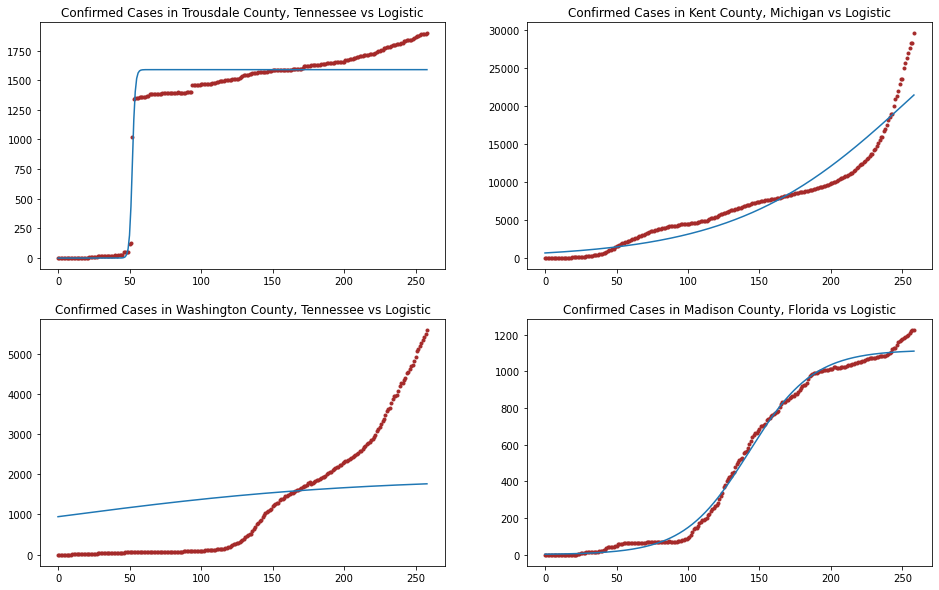

In [13]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

# Fit a mixture of two logistic curves

A mixture of two logistic curves with different starting points can explain the data for disease
outbreaks involving two distinct waves.

In [14]:
log2_df = fit_logistic2(ts_col_name)
log2_df

/Users/freiss/pd/cn-update/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


/Users/freiss/pd/cn-update/env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,"{'fun': 317291.03208654304, 'jac': [-945.12868...",712.386798,0.072317,117.666975,6595.429632,0.000972,258.999811,211.681399,258.999964,[ 28.84265226 29.47606541 30.12364459 30...,0.998202
1003,Alabama,Baldwin,223234,573,0,"{'fun': 26853525.23307314, 'jac': [9462.602380...",989.860929,0.000000,37.533129,8534.774774,0.037192,155.780454,0.000000,133.331887,[ 265.70155073 265.30291246 264.92597651 264...,0.986051
1005,Alabama,Barbour,24686,31,1,"{'fun': 1090773.9485362135, 'jac': [0.0, 0.0, ...",923.883669,9.780670,29.777387,954.668952,0.038310,125.773999,12.472659,11.472668,[7.26384030e-08 2.05098635e-07 5.79100551e-07 1...,0.972747
1007,Alabama,Bibb,22394,149,0,"{'fun': 55959.529265288176, 'jac': [-39.552523...",1037.938977,0.105521,236.273356,1083.114902,0.035398,138.899231,0.028724,259.000000,[ 3.89092371 4.03793868 4.19045362 4...,0.998005
1009,Alabama,Blount,57826,189,2,"{'fun': 100261862.71273577, 'jac': [8.94068962...",880.093449,9.957865,27.595491,1362.224234,0.015063,51.618109,16.795297,15.795297,[5.40108077e-08 1.48336048e-07 4.07372177e-07 1...,0.453860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,"{'fun': 2653299.025831652, 'jac': [0.0, 2.7474...",1803.509889,0.071085,259.000000,2043.562076,0.024209,259.000000,10.000051,20.000019,[6.48186571e-01 7.21136490e-01 8.01099864e-01 8...,0.874243
56039,Wyoming,Teton,23464,241,0,"{'fun': 888724.0346418495, 'jac': [-0.13969986...",2046.427809,0.022727,259.000000,2317.021100,0.018087,259.000000,10.000025,19.999971,[ 8.2777716 8.67834295 9.10516567 9...,0.967809
56041,Wyoming,Uinta,20226,190,0,"{'fun': 965563.893177926, 'jac': [0.0, -0.0, 0...",1216.157278,10.000000,259.000000,1377.965813,0.015854,259.000000,4.508973,33.314464,[ 9.14988175 9.48469471 9.82883674 10.182...,0.915456


## Graph: Examples of logistic curve mixtures

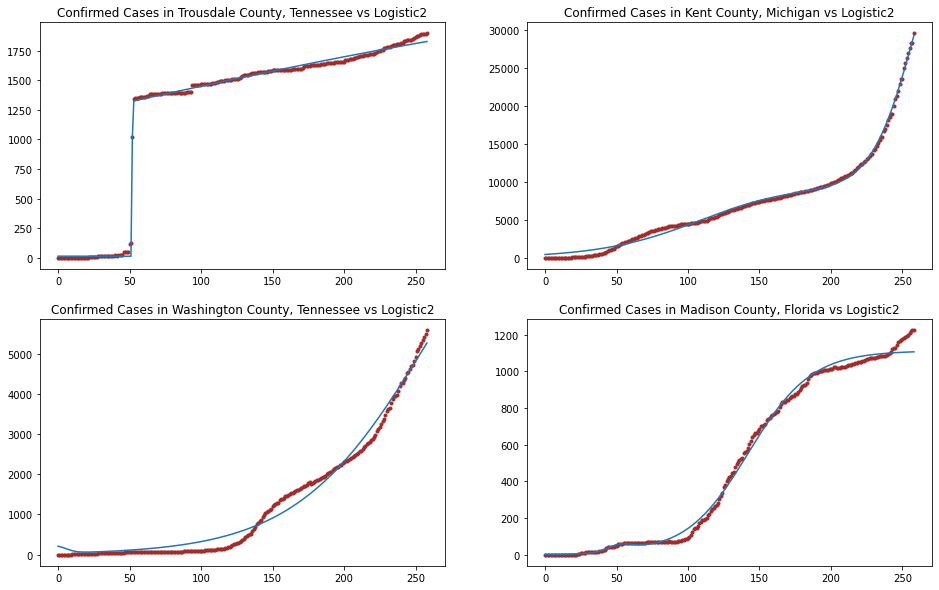

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

# Save the curves

Save the coefficients of the curves we just fit to disk, so that [`analyze_fit_us_data.ipynb`](analyze_fit_us_data.ipynb)
can reconstruct the curves and compare them to the underlying time series.

In [16]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03268179e+00 1.06643168e+00 1...,[ 39.07588299 40.05937659 41.06722489 42...,[ 28.84265226 29.47606541 30.12364459 30...
1003,Alabama,Baldwin,223234,573,0,[ 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03739188e+00 1.07618191e+00 1...,[ 34.54996183 35.697209 36.88236758 38...,[ 265.70155073 265.30291246 264.92597651 264...
1005,Alabama,Barbour,24686,31,1,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02964589e+00 1.06017065e+00 1...,[ 20.91097258 21.47629938 22.05660754 22...,[7.26384030e-08 2.05098635e-07 5.79100551e-07 1...
1007,Alabama,Bibb,22394,149,0,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02892515e+00 1.05868696e+00 1...,[ 15.69551022 16.06587096 16.44484264 16.832...,[ 3.89092371 4.03793868 4.19045362 4...
1009,Alabama,Blount,57826,189,2,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03265475e+00 1.06637584e+00 1...,[ 16.48050222 16.9434894 17.4193997 17...,[5.40108077e-08 1.48336048e-07 4.07372177e-07 1...
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02824538e+00 1.05728857e+00 1...,[ 3.84415638 3.93823724 4.03461606 4...,[6.48186571e-01 7.21136490e-01 8.01099864e-01 8...
56039,Wyoming,Teton,23464,241,0,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02910053e+00 1.05904789e+00 1...,[ 20.95561488 21.33565057 21.72251319 22...,[ 8.2777716 8.67834295 9.10516567 9...
56041,Wyoming,Uinta,20226,190,0,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.02712193 1.05497947 1.083...,[ 19.9218464 20.24534842 20.57402494 20.907...,[ 9.14988175 9.48469471 9.82883674 10.182...


In [17]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               153   
      2020-03-11  Alabama  Autauga       55869               153   
      2020-03-12  Alabama  Autauga       55869               153   
      2020-03-13  Alabama  Autauga       55869               153   
      2020-03-14  Alabama  Autauga       55869               153   
...                   ...      ...         ...               ...   
56045 2020-11-19  Wyoming   Weston        6927                34   
      2020-11-20  Wyoming   Weston        6927                34   
      2020-11-21  Wyoming   Weston        6927                34   
      2020-11-22  Wyoming   Weston        6927                34   
      2020-11-23  Wyoming   Weston        6927                34   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              3          0              False     1.000000   
      2020-03-11              3          0              False     1.032682   
      2020-03-12              3          0              False     1.066432   
      2020-03-13              3          0              False     1.101285   
      2020-03-14              3          0              False     1.137277   
...                         ...        ...                ...          ...   
56045 2020-11-19              1        355              False   374.457859   
      2020-11-20              1        364              False   390.161780   
      2020-11-21              1        366              False   406.524288   
      2020-11-22              1        372              False   423.573003   
      2020-11-23              1        372              False   441.336703   

                    Logistic   Logistic2  
FIPS  Date                                
1001  2020-03-10   39.075883   28.842652  
      2020-03-11   40.059377   29.476065  
      2020-03-12   41.067225   30.123645  
      2020-03-13   42.100011   30.785730  
      2020-03-14   43.158330   31.462672  
...                      ...         ...  
56045 2020-11-19  365.682229  365.682191  
      2020-11-20  374.435530  374.435458  
      2020-11-21  382.984690  382.984581  
      2020-11-22  391.316682  391.316532  
      2020-11-23  399.420159  399.419968  

[769230 rows x 10 columns]

In [18]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [19]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,0.032159,0.000000,2588.942416,0.025243,165.522271,712.386798,0.072317,117.666975,6595.429632,0.000972,258.999811,211.681399,258.999964
1003,Alabama,Baldwin,223234,573,0,0.036710,0.000000,7693.435432,0.032816,164.591587,989.860929,0.000000,37.533129,8534.774774,0.037192,155.780454,0.000000,133.331887
1005,Alabama,Barbour,24686,31,1,0.029215,0.000000,1136.381406,0.027183,146.296390,923.883669,9.780670,29.777387,954.668952,0.038310,125.773999,12.472659,11.472668
1007,Alabama,Bibb,22394,149,0,0.028515,0.000000,1135.701311,0.023653,180.428326,1037.938977,0.105521,236.273356,1083.114902,0.035398,138.899231,0.028724,259.000000
1009,Alabama,Blount,57826,189,2,0.032133,0.000000,2726.924145,0.027876,183.046371,880.093449,9.957865,27.595491,1362.224234,0.015063,51.618109,16.795297,15.795297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,0.027854,0.000000,2044.183641,0.024225,259.000000,1803.509889,0.071085,259.000000,2043.562076,0.024209,259.000000,10.000051,20.000019
56039,Wyoming,Teton,23464,241,0,0.028685,0.000000,2319.836531,0.018138,259.000000,2046.427809,0.022727,259.000000,2317.021100,0.018087,259.000000,10.000025,19.999971
56041,Wyoming,Uinta,20226,190,0,0.026761,0.000000,1393.049826,0.016344,259.000000,1216.157278,10.000000,259.000000,1377.965813,0.015854,259.000000,4.508973,33.314464


In [20]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
